# Goal

The idea behind this code is to plot some key examples from the A/MSU data; these visualizations help us check our work and understand how it relates to the radiosonde data (explored more in /igra/ directory).

We plot:

1. The timeseries of tropical (between 25S and 25N) brightness temperatures (Tb) over the period of record (1979-2017.5)
2. The seasonal cycle of the tropical Tb
3. An example timeseries at a specific location (Majuro Island, stn_id='RMM00091376', 7.1° N, 171.2° E)
4. A map with the amplitude of the seasonal cycle of Tb
5. A map with the long-term trends of Tb

## Setup

In [1]:
% add the path for functions
addpath('/Users/dgilford/ncar_summer_2017/gr_radiosondes/fx_library');

## Load MSU Data

In [2]:
msu_filepath='/Users/dgilford/ncar_summer_2017/gr_radiosondes/msu/data/MSU_gridded_data.mat';
load(msu_filepath);
whos

  Name                Size                   Bytes  Class     Attributes

  Tb                144x72x468            38817792  double              
  msu_filepath        1x77                     154  char                
  msu_latgrid        72x1                      288  single              
  msu_longrid       144x1                      576  single              
  msu_timegrid        1x468                   3744  double              



## Visualize MSU Data

### 1. Timeseries of Tropical Brightness Temperatures

In [3]:
% get the tropical latitude indices: reduce the latitude grid of the data to between 25S and 25N
trop_lat=[-25 25];
[~,trop_inds] = reduce_grid(msu_latgrid,trop_lat);

In [8]:
% set the nanswitch to zero
nanswitch=0;

% take the zonal/meridional averages of brightness temperatures over the tropics
Tb_zonal=squeeze(nanmean(Tb,1));
for t=1:length(msu_timegrid);
    Tb_trop(t,1)=merid_mean(squeeze(Tb_zonal(trop_inds,t)),msu_latgrid(trop_inds),nanswitch);
end

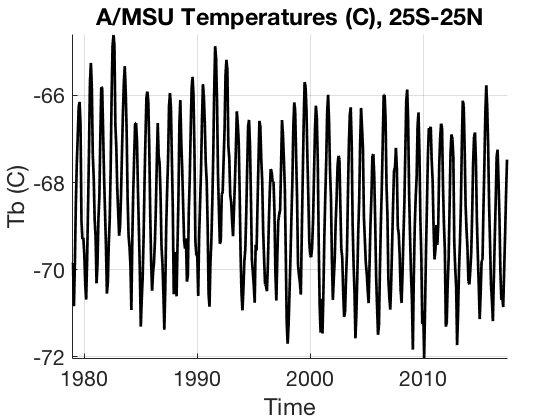

In [26]:
% plot the result
figure(1);
set(gcf,'color','w')
set(gca,'FontSize',16)
hold on
    plot(msu_timegrid,Tb_trop-273.15,'k','LineWidth',2);
    axis('tight')
    xlabel('Time')
    ylabel('Tb (C)')
    grid
    title('A/MSU Temperatures (C), 25S-25N')
hold off

### 2. Seasonal Cycle of Tropical Brightness Temperatures

In [29]:
% get the seasonal cycle over the tropical averages, convert to y/m format
nyear=length(msu_timegrid)/12;
for yr=1:nyear
    for m=1:12
        tind=((yr-1)*12)+m;
        Tb_ym(yr,m)=squeeze(Tb_trop(tind));
    end
end
% get the average over all years for each month, ignore months that are missing (just 7-12/2017)
Tb_seas=squeeze(nanmean(Tb_ym,1));

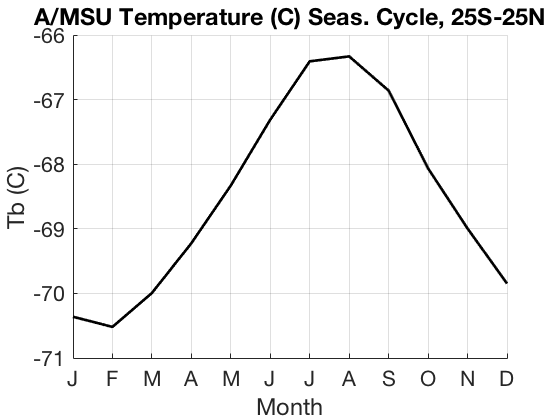

In [30]:
% plot the result
mon_labels={'J','F','M','A','M','J','J','A','S','O','N','D'};
figure(2);
set(gcf,'color','w')
set(gca,'FontSize',16)
hold on
    plot(1:12,Tb_seas-273.15,'k','LineWidth',2);
    xlim([1 12])
    xticks(1:12)
    xticklabels(mon_labels)
    xlabel('Month')
    ylabel('Tb (C)')
    grid
    title('A/MSU Temperature (C) Seas. Cycle, 25S-25N')
hold off

### 3. Timeseries Nearest Majuro

To find the A/MSU location closest to the station, we could take lat/lon that each fall closest to the lat/lon of the station, but because of the earth's curvature we may not actually identify the correct location. Instead, we identify the 3 closest indices for MSU lat/lon and then compute the distance between that and the station using the haversine formula (see: https://www.mathworks.com/matlabcentral/fileexchange/27785-distance-calculation-using-haversine-formula).

In [72]:
% set majuro lat and lon
stn_lat=7.1; stn_lon=171.2;

% narrow to lat/lon indices closest to majuro
lati=find(abs(msu_latgrid-stn_lat)==min(abs(msu_latgrid-stn_lat)));
loni=find(abs(msu_longrid-stn_lon)==min(abs(msu_longrid-stn_lon)));
latmax=lati+1; latmin=lati-1; lonmax=loni+1; lonmin=loni-1;
% account for earth wrapping
if loni==length(msu_longrid)
    lonmax=1
    reduced_lon=msu_longrid([lonmax,lonmin,loni])
elseif loni==1
    lonmin=length(msu_longrid)
    reduced_lon=msu_longrid([loni,lonmax,lonmin])
else
    reduced_lon=msu_longrid(lonmin:lonmax);
end
reduced_lat=msu_latgrid(latmin:latmax);
[Xmesh,Ymesh] = meshgrid(reduced_lon,reduced_lat);

% then find closest to majuro with haversine method
for y=1:3
    for x=1:3
        [hav_xy(x,y),~,~]=haversine([stn_lat stn_lon],[reduced_lat(y) reduced_lon(x)]);
    end
end
% find the minimum and its location
[A,~]=min(min(hav_xy));
I=find(hav_xy==A);
% get the indices
[min_xi,min_yi] = ind2sub(size(hav_xy),I);
stn_xi=find(msu_longrid==reduced_lon(min_xi)); stn_yi=find(msu_latgrid==reduced_lat(min_xi));

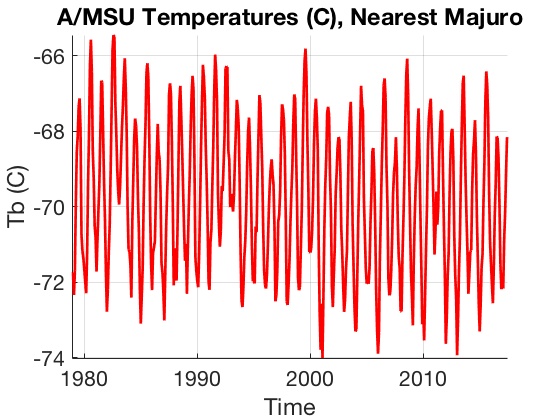

In [70]:
% plot the result
figure(3);
set(gcf,'color','w')
set(gca,'FontSize',16)
hold on
    plot(msu_timegrid,squeeze(Tb(stn_xi,stn_yi,:))-273.15,'r','LineWidth',2);
    axis('tight')
    xlabel('Time')
    ylabel('Tb (C)')
    grid
    title('A/MSU Temperatures (C), Nearest Majuro')
hold off

### 4. Mapped Amplitude of Seasonal Cycle

Here we plot the amplitude of the Tb seasonal cycle over the tropics, which shows how the structure can change over the regions.

In [75]:
% get the seasonal cycle at every horizontal location
Tb_ym=nan(length(msu_longrid),length(msu_latgrid),nyear,12);
for yr=1:nyear
    for m=1:12
        tind=((yr-1)*12)+m;
        Tb_ym(:,:,yr,m)=squeeze(Tb(:,:,tind));
    end
end
Tb_seas_xy=squeeze(nanmean(Tb_ym,3));

In [92]:
% calculate the amplitude
Tb_amp=range(Tb_seas_xy,3);

% flip the sign of the amplitude if it is opposite the tropical amplitude (max in summer, min in winter)
Tb_amp_flipped=Tb_amp;
Tb_amp_flipped(Tb_seas_xy(:,:,1) > Tb_seas_xy(:,:,7))=-Tb_amp_flipped(Tb_seas_xy(:,:,1) > Tb_seas_xy(:,:,7));

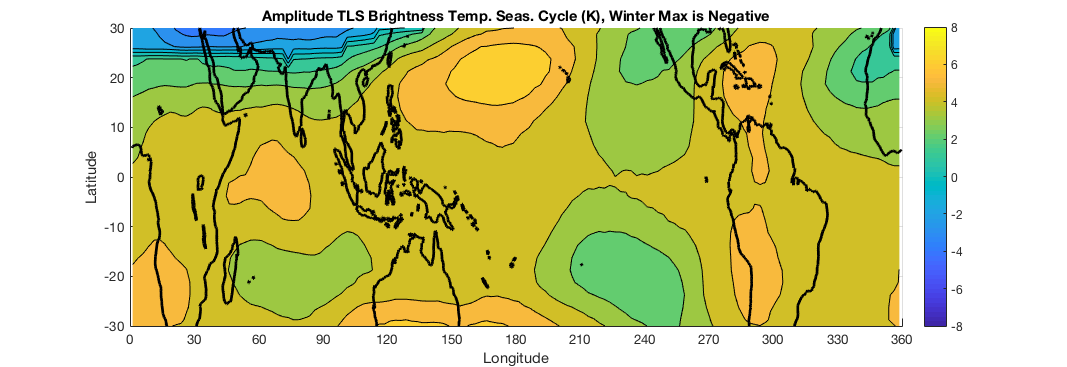

In [100]:
h1=figure(4);
hold on
    clevels=-8:1:8;
    contourf(msu_longrid,msu_latgrid,Tb_amp_flipped',clevels);
    xlim([0 360])
    ylim([-30 30])
    xlabel('Longitude')
    ylabel('Latitude')
    title('Amplitude TLS Brightness Temp. Seas. Cycle (K), Winter Max is Negative')
    set(gca,'YTick',-30:10:30);
    set(gca,'XTick',0:30:360);
    % plot the coastline
    load coast;
    long(long<0)=long(long<0)+360;
    lat(long<0.5)=NaN;
    plot(long,lat,'k','LineWidth',2)
    colorbar
    grid
hold off
set(h1, 'Position', [200 200 800 275])
set(h1,'PaperPositionMode','auto')

### 4. Mapped Long-term Trends of A/MSU

We can calculate view the trends of satellite period.

In [107]:
% calculate the trends at every lat/lon
msu_slope=nan(length(msu_longrid),length(msu_latgrid));
for x=1:length(msu_longrid)
    for y=1:length(msu_latgrid)
        % get the timeseries at each location
        ts_loc=squeeze(Tb(x,y,:));
        % require the locations to have at least 300 months of data to calculate the A/MSU trends
        if sum(~isnan(ts_loc))>300
            % calculate the trend over all points without missing data (here just 7-12/2017)
            p=polyfit(msu_timegrid(~isnan(ts_loc)),ts_loc(~isnan(ts_loc))',1);
            msu_slope(x,y)=p(1);
        end
    end
end
% convert slope to decadal trend
msu_trend=msu_slope.*10;

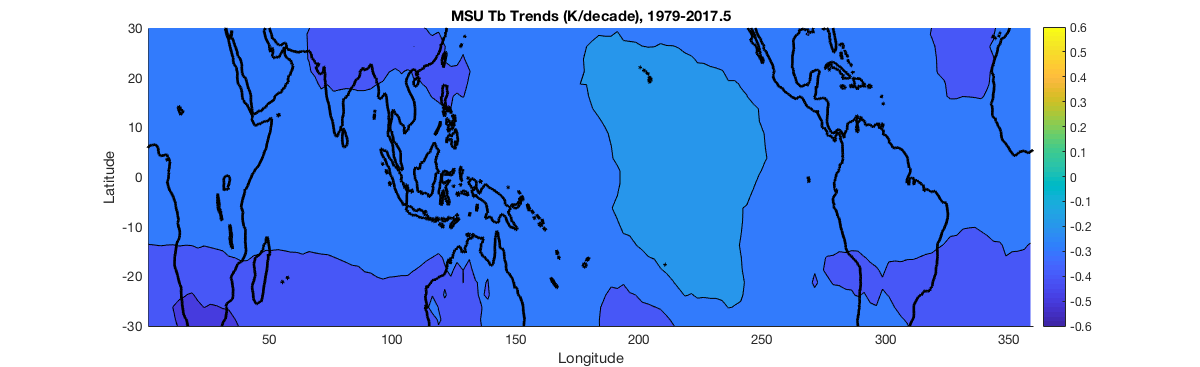

In [112]:
% plot the result
clevels=-0.6:0.1:0.6;
h2=figure(5);
hold on
    contourf(msu_longrid,msu_latgrid,msu_trend',clevels);
    c1=colorbar('Ticks',clevels);
    caxis([clevels(1) clevels(end)])
    plot(long,lat,'k','LineWidth',2)
    ylim([-30 30])
    title('MSU Tb Trends (K/decade), 1979-2017.5')
    ylabel('Latitude')
    xlabel('Longitude')
hold off
set(h2, 'Position', [200 300 900 275])
set(h2,'PaperPositionMode','auto')